In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
ab = pd.read_csv('../data/pitch/atbats.csv')

In [4]:
ab.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [5]:
ab2018 = ab.loc[ab.ab_id.astype(str).str.startswith('2018')]
ab2018['game_num'] = [int(x[-4:])//15 + 1 for x in ab2018.g_id.astype(str)]

In [6]:
names = pd.read_csv('../data/pitch/player_names.csv')

In [7]:
named_ab = pd.merge(ab2018, names, left_on = 'batter_id', right_on = 'id', how = 'left')
first, last = ['Mookie', 'Mike', 'Jose', 'J.D.', 'Alex'], ['Betts', 'Trout', 'Ramirez', 'Martinez', 'Bregman']
mvps = named_ab.loc[(named_ab.first_name.isin(first)) & (named_ab.last_name.isin(last))]

In [9]:
trout = mvps.loc[mvps.last_name == 'Trout']
betts = mvps.loc[mvps.last_name == 'Betts']
martinez = mvps.loc[(mvps.last_name == 'Martinez') & (mvps.first_name == 'J.D.')]
ramirez = mvps.loc[mvps.last_name == 'Ramirez']
bregman = mvps.loc[mvps.last_name == 'Bregman']

In [39]:
mvps.event.unique()

array(['Groundout', 'Flyout', 'Pop Out', 'Strikeout', 'Walk', 'Single',
       'Forceout', 'Grounded Into DP', 'Double', 'Home Run', 'Lineout',
       'Runner Out', 'Fielders Choice', 'Hit By Pitch', 'Sac Fly',
       'Triple', 'Intent Walk', 'Field Error', 'Batter Interference',
       'Fielders Choice Out', 'Double Play', 'Strikeout - DP',
       'Catcher Interference', 'Sac Bunt'], dtype=object)

In [27]:
def game_count(df):
    ct = [1]
    i = 1
    for j, game_id in enumerate(df.iloc[1:,3]):
        if game_id == df.iloc[j,3]:
            ct.append(i)
        else:
            i += 1
            ct.append(i)
    df['game_count'] = ct
    return df

#  clean up code, yikes

In [40]:
on_base = ['Walk', 'Single', 'Double', 'Home Run', 'Hit By Pitch', 'Triple', 'Intent Walk']

In [41]:
def create_cols(df, roll):
    # create ab bat index
    df['ab_num'] = df.reset_index().index + 1 - roll
    # create on base percentage over rolling 50 at bats
    df['on_base_flag'] = np.where(df.event.isin(on_base), 1, 0)
    df['ob_pct'] = df.on_base_flag.rolling(roll).sum() / roll
    # create sum of HR's over rolling 50 at bats
    df['HR'] = np.where(df.event == 'Home Run', 1, 0)
    df['HR_rolling'] = df.HR.rolling(roll).sum()
    # create slugging percentage, ie total bases / at bats
    df['total_bases'] = 0
    df.loc[(df.event.isin(['Walk', 'Single', 'Hit By Pitch', 'Intent Walk'])), 'total_bases'] = 1
    df.loc[df.event == 'Double', 'total_bases'] = 2
    df.loc[df.event == 'Triple', 'total_bases'] = 3
    df.loc[df.event == 'Home Run', 'total_bases'] = 4
    df['Slugging'] = df.total_bases.rolling(roll).mean()
    # create obp+s
    df['obps'] = df.ob_pct + df.Slugging
    # keep only desired columns
    df = df[['first_name', 'last_name', 'game_num', 'ab_num', 'event','on_base_flag', 'ob_pct', 
             'Slugging', 'obps', 'HR_rolling']]
    # drop na rows
    df = df.dropna()
    #df = df.loc[df.game_num % 5 == 0]
    return df

In [42]:
trout = create_cols(trout, 100)
betts = create_cols(betts, 100)
martinez = create_cols(martinez, 100)
ramirez = create_cols(ramirez, 100)
bregman = create_cols(bregman, 100)

In [43]:
trout.tail(10)

,first_name,last_name,game_num,ab_num,event,on_base_flag,ob_pct,Slugging,obps,HR_rolling
181283,Mike,Trout,159,499,Strikeout,0,0.46,0.70,1.16,7.0
182632,Mike,Trout,160,500,Pop Out,0,0.45,0.69,1.14,7.0
182648,Mike,Trout,160,501,Home Run,1,0.46,0.73,1.19,8.0
182667,Mike,Trout,160,502,Single,1,0.47,0.74,1.21,8.0
182683,Mike,Trout,160,503,Intent Walk,1,0.48,0.75,1.23,8.0
183923,Mike,Trout,161,504,Flyout,0,0.47,0.74,1.21,8.0
183943,Mike,Trout,161,505,Strikeout,0,0.47,0.74,1.21,8.0
183959,Mike,Trout,161,506,Flyout,0,0.46,0.73,1.19,8.0
183971,Mike,Trout,161,507,Flyout,0,0.46,0.73,1.19,8.0
184993,Mike,Trout,162,508,Lineout,0,0.46,0.73,1.19,8.0


In [44]:
combined = pd.concat([trout, betts, martinez, ramirez, bregman])

In [45]:
%R -i combined

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



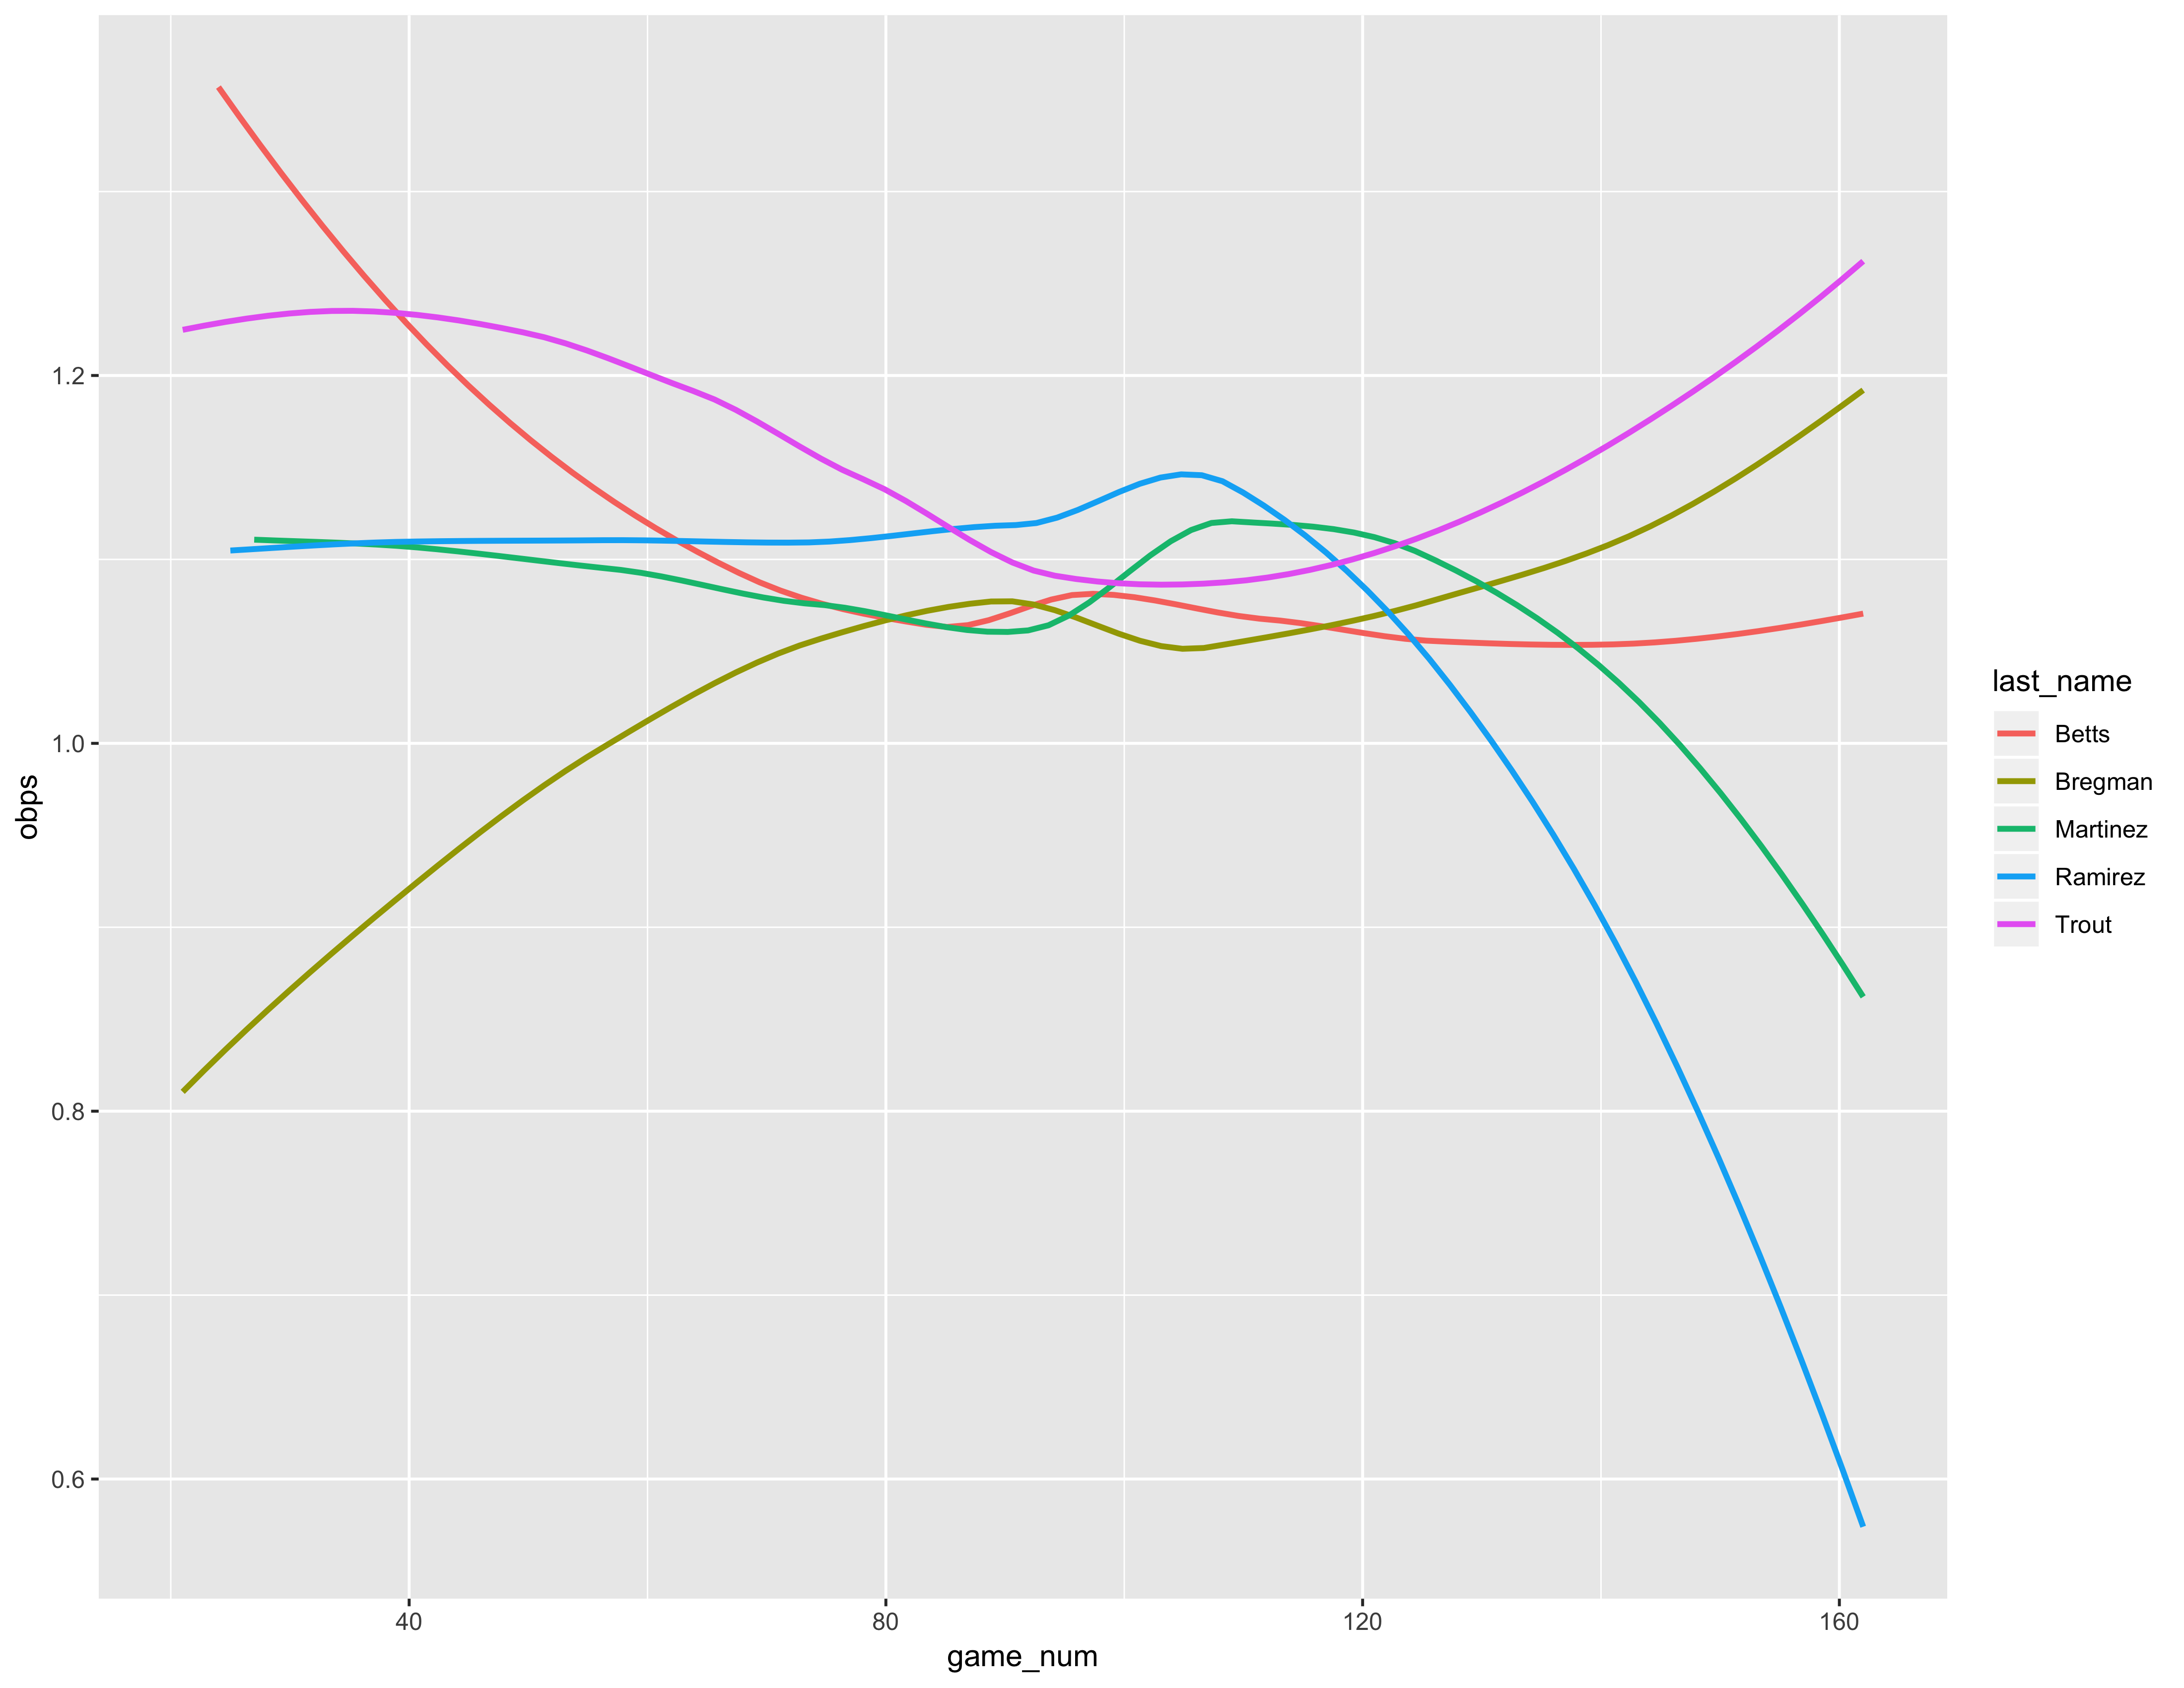

In [52]:
%%R -w 11 -h 8.5 --units in -r 400

ggplot() + geom_smooth(aes(x=game_num, y = obps, group = last_name, color = last_name), 
                       data = combined, span = 0.9, se = F)